In [1]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# Specify YOUR working directory:
main_dir = 'YOUR_MAIN_DIR'

# Setup:

In [3]:
!nvidia-smi

Sun Mar  6 07:36:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

# Installing Packages

In [5]:
import os
os.chdir(main_dir)

!pip install './install/torch-1.7.1+cu110-cp37-cp37m-linux_x86_64.whl' --no-deps
!pip install './install/torchvision-0.8.2+cu110-cp37-cp37m-linux_x86_64.whl' --no-deps
!pip install './install/torchaudio-0.7.2-cp37-cp37m-manylinux1_x86_64.whl' --no-deps

!pip install './install/addict-2.4.0-py3-none-any.whl' --no-deps
!pip install './install/yapf-0.31.0-py2.py3-none-any.whl' --no-deps
!pip install './install/terminal-0.4.0-py3-none-any.whl' --no-deps
!pip install './install/terminaltables-3.1.0-py3-none-any.whl' --no-deps
!pip install './install/mmcv_full-1.3.17-cp37-cp37m-manylinux1_x86_64.whl' --no-deps
!pip install './install/pycocotools-2.0.2' --no-deps
!pip install './install/mmpycocotools-12.0.3' --no-deps

!pip install ensemble-boxes

os.chdir(main_dir + '/install/')
!git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .
import mmseg


os.chdir(main_dir)
%cd ./install/mmdetection-2.18.0
!pip install -e .
import mmdet

!pip install albumentations==0.4.6

os.chdir(main_dir + '/install/')
!git clone https://github.com/microsoft/SoftTeacher/
%cd SoftTeacher
!python setup.py develop
from ssod.utils import patch_config
%cd -

os.chdir(main_dir)

import sys
sys.path.insert(1,main_dir + '/install/content/SoftTeacher')

Processing ./install/torch-1.7.1+cu110-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
Processing ./install/torchvision-0.8.2+cu110-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
Processing ./install/torchaudio-0.7.2-cp37-cp37m-manylinux1_x86_64.whl
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.10.0+cu111
    Uninstalling torchaudio-0.10.0+cu111:
      Successfully uninstalled torchaudio-0.10.0+cu111
Processing ./install/addict-2.4.0-py3-none-any.whl
Processing ./install/yapf-0.31.0-py2.py3-none-any.whl
Processing ./install/terminal-0.4.0-py3-none-any.whl
Processing ./install/terminaltables-3.1.0-py3-none-any.whl
Processing ./install/

In [6]:
import torch
print(torch.__version__)
print("mmcv_full:")
!pip show mmcv_full |grep Version
print("mmdet:")
!pip show mmdet |grep Version
print("mmseg:")
print(mmseg.__version__)

1.7.1+cu110
mmcv_full:
Version: 1.3.17
mmdet:
Version: 2.18.0
mmseg:
0.21.1


# Imports

In [7]:
import sys
import os
import numpy as np
# Soft Teacher
import argparse
import os.path as osp
import time
import warnings

import mmcv
import torch
from mmcv import Config, DictAction
from mmcv.cnn import fuse_conv_bn
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmcv.runner import get_dist_info, init_dist, load_checkpoint, wrap_fp16_model
from mmdet.apis import multi_gpu_test, single_gpu_test
from mmdet.datasets import build_dataloader, build_dataset, replace_ImageToTensor
from mmdet.models import build_detector
from mmdet.core.visualization import imshow_det_bboxes

from ssod.utils import patch_config

# WBF
import pickle
import json
from ensemble_boxes import *

# SEG
sys.path.append(main_dir + '/install/')
import seg_swin_cell_modules
import cv2
cv2.setNumThreads(0)

import argparse
import os.path as osp
import shutil
import time
from mmcv.utils import DictAction
from mmseg.apis import multi_gpu_test, single_gpu_test
from mmseg.datasets import build_dataloader, build_dataset
from mmseg.models import build_segmentor

# Helper Functions

In [8]:
def wbf_si(bbox_models,img_scale,weights,iou_thr,skip_box_thr):
    num_of_models = 0
    if any(isinstance(i, list) for i in bbox_models[0]):
        num_of_models = len(bbox_models)
        num_of_imgs = len(bbox_models[0])
        num_of_classes = len(bbox_models[0][0])
        res = [[]] * num_of_imgs
    else:
        num_of_models = 1
        num_of_imgs = len(bbox_models)
        num_of_classes = len(bbox_models[0])
        res = [[]] * num_of_imgs
    HIEGHT = img_scale[0]
    WIDTH = img_scale[1]
    for i in range(num_of_imgs):
        res[i] = [[]] * num_of_classes
        for j in range(num_of_classes):
            boxes_list = []
            scores_list = []
            labels_list = []
            for m in range(num_of_models):
                if num_of_models > 1:
                    instance_array = bbox_models[m][i][j]
                    num_of_instances = np.size(instance_array,0)
                elif num_of_models == 1:
                    instance_array = bbox_models[i][j]
                    num_of_instances = np.size(instance_array, 0)
                bbox = []
                score = []
                lbl = [j] * num_of_instances
                for k in range(num_of_instances):
                    bbox.append([instance_array[k][0] / WIDTH, instance_array[k][1] / HIEGHT,
                                  instance_array[k][2] / WIDTH,
                                  instance_array[k][3] / HIEGHT])
                    score.append(instance_array[k][-1])
                boxes_list.append(bbox)
                scores_list.append(score)
                labels_list.append(lbl)

            if num_of_instances > 0:
                boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights,
                                                          iou_thr=iou_thr, skip_box_thr=skip_box_thr)
            else:
                boxes, scores, labels = [[]] * 3

            bbox_array = np.zeros(shape=(len(scores),5), dtype=np.float32)
            for m in range(len(boxes)):
                bbox_array[m,:] = [boxes[m][0] * WIDTH, boxes[m][1] * HIEGHT, boxes[m][2] * WIDTH, boxes[m][3] * HIEGHT, scores[m]]
            res[i][j]=bbox_array
    return res


def pkl_labels_fuc(pkl, j):
    class0_n=len(pkl[j][0])
    class1_n=len(pkl[j][1])
    class2_n=len(pkl[j][2])
    pkl_labels=[]
    for i in range(class0_n):
        pkl_labels.append(0)
    for i in range(class1_n):
        pkl_labels.append(1)
    for i in range(class2_n):
        pkl_labels.append(2)
    
    return np.asarray(pkl_labels)

def evaluate_and_show(dataset,
                      results,
                      topk=20,
                      show_dir='work_dir',
                      eval_fn=None):
                      #self
    """Evaluate and show results.
    Args:
        dataset (Dataset): A PyTorch dataset.
        results (list): Det results from test results pkl file
        topk (int): Number of the highest topk and
            lowest topk after evaluation index sorting. Default: 20
        show_dir (str, optional): The filename to write the image.
            Default: 'work_dir'
        eval_fn (callable, optional): Eval function, Default: None
    """

    assert topk > 0
    if (topk * 2) > len(dataset):
        topk = len(dataset) // 2

    if eval_fn is None:
        eval_fn = bbox_map_eval
    else:
        assert callable(eval_fn)

    prog_bar = mmcv.ProgressBar(len(results))
    _mAPs = {}
    for i, (result, ) in enumerate(zip(results)):
        # self.dataset[i] should not call directly
        # because there is a risk of mismatch
        data_info = dataset.prepare_train_img(i)
        mAP = eval_fn(result, data_info['ann_info'])
        _mAPs[i] = mAP
        prog_bar.update()

    # descending select topk image
    _mAPs = list(sorted(_mAPs.items(), key=lambda kv: kv[1]))
    good_mAPs = _mAPs[-topk:]
    bad_mAPs = _mAPs[:topk]

    good_dir = osp.abspath(osp.join(show_dir, 'good'))
    bad_dir = osp.abspath(osp.join(show_dir, 'bad'))
    #self._save_image_gts_results(dataset, results, good_mAPs, good_dir)
    #self._save_image_gts_results(dataset, results, bad_mAPs, bad_dir)

def bbox_map_eval(det_result, annotation):
    """Evaluate mAP of single image det result.
    Args:
        det_result (list[list]): [[cls1_det, cls2_det, ...], ...].
            The outer list indicates images, and the inner list indicates
            per-class detected bboxes.
        annotation (dict): Ground truth annotations where keys of
             annotations are:
            - bboxes: numpy array of shape (n, 4)
            - labels: numpy array of shape (n, )
            - bboxes_ignore (optional): numpy array of shape (k, 4)
            - labels_ignore (optional): numpy array of shape (k, )
    Returns:
        float: mAP
    """

    # use only bbox det result
    if isinstance(det_result, tuple):
        bbox_det_result = [det_result[0]]
    else:
        bbox_det_result = [det_result]
    # mAP
    iou_thrs = np.linspace(
        .5, 0.95, int(np.round((0.95 - .5) / .05)) + 1, endpoint=True)
    mean_aps = []
    for thr in iou_thrs:
        mean_ap, _ = eval_map(
            bbox_det_result, [annotation], iou_thr=thr, logger='silent')
        mean_aps.append(mean_ap)
    return sum(mean_aps) / len(mean_aps)


def show_det_image(pkl, annot_dict, img, j):
        pkl_bboxes = np.concatenate((pkl[j][0],pkl[j][1],pkl[j][2]))
        pkl_labels = pkl_labels_fuc(pkl, j)

        imshow_det_bboxes(img,
                          pkl_bboxes,
                          pkl_labels,
                          segms=None,
                          class_names=["shsy5y", "cort", "astro"],
                          score_thr=0.2,
                          show=True)
        
def DET_INFER(out, json_file, config, checkpoint, show, eval, data_annot_file_dir, data_test_dir):
        args = {
            "out": out,
            "json_file": json_file,
            "config": config,
            "eval": eval,
            "checkpoint": checkpoint,
            "show": show
        }

        print(args["config"])

        cfg = Config.fromfile(args["config"])

        cfg.data.test.ann_file = data_annot_file_dir
        cfg.data.test.img_prefix =  data_test_dir 
        
        if "pretrained" in cfg.model:
            cfg.model.pretrained = None
        if cfg.model.get("neck"):
            if isinstance(cfg.model.neck, list):
                for neck_cfg in cfg.model.neck:
                    if neck_cfg.get("rfp_backbone"):
                        if neck_cfg.rfp_backbone.get("pretrained"):
                            neck_cfg.rfp_backbone.pretrained = None
            elif cfg.model.neck.get("rfp_backbone"):
                if cfg.model.neck.rfp_backbone.get("pretrained"):
                    cfg.model.neck.rfp_backbone.pretrained = None

        # in case the test dataset is concatenated
        samples_per_gpu = 1
        if isinstance(cfg.data.test, dict):
            cfg.data.test.test_mode = True
            samples_per_gpu = cfg.data.test.pop("samples_per_gpu", 1)
            if samples_per_gpu > 1:
                # Replace 'ImageToTensor' to 'DefaultFormatBundle'
                cfg.data.test.pipeline = replace_ImageToTensor(cfg.data.test.pipeline)
        elif isinstance(cfg.data.test, list):
            for ds_cfg in cfg.data.test:
                ds_cfg.test_mode = True
            samples_per_gpu = max(
                [ds_cfg.pop("samples_per_gpu", 1) for ds_cfg in cfg.data.test]
            )
            if samples_per_gpu > 1:
                for ds_cfg in cfg.data.test:
                    ds_cfg.pipeline = replace_ImageToTensor(ds_cfg.pipeline)

        distributed = False


        cfg = patch_config(cfg)
        # build the dataloader
        dataset = build_dataset(cfg.data.test)
        data_loader = build_dataloader(
            dataset,
            samples_per_gpu=samples_per_gpu,
            workers_per_gpu=cfg.data.workers_per_gpu,
            dist=distributed,
            shuffle=False,
        )

        # build the model and load checkpoint
        cfg.model.train_cfg = None
        model = build_detector(cfg.model, test_cfg=cfg.get("test_cfg"))
        fp16_cfg = cfg.get("fp16", None)
        if fp16_cfg is not None:
            wrap_fp16_model(model)
        checkpoint = load_checkpoint(model, args["checkpoint"], map_location="cpu")

        # old versions did not save class info in checkpoints, this walkaround is
        # for backward compatibility
        if "CLASSES" in checkpoint.get("meta", {}):
            model.CLASSES = checkpoint["meta"]["CLASSES"]
        else:
            model.CLASSES = dataset.CLASSES

        if not distributed:
            model = MMDataParallel(model, device_ids=[0])
            outputs = single_gpu_test(
                model, data_loader, args["show"] 
            )


        print(f"\nwriting results to output_dir")
        mmcv.dump(outputs, args["out"])
        kwargs = {}

        eval_kwargs = cfg.get("evaluation", {}).copy()
        # hard-code way to remove EvalHook args
        for key in [
            "type",
            "interval",
            "tmpdir",
            "start",
            "gpu_collect",
            "save_best",
            "rule",
        ]:
            eval_kwargs.pop(key, None)
        eval_kwargs.update(dict(metric=args["eval"], **kwargs))


def SEG_INFER(out, json_file, config, checkpoint, pred_file_path, eval, data_annot_file_dir, data_test_dir):

        args_seg = {
          "out": out, 
          "json_file": json_file,
          "config": config,
          "eval": eval, 
          "checkpoint": checkpoint,
          "pred_file_path": pred_file_path 
        }

        cfg = mmcv.Config.fromfile(args_seg["config"])



        ############
        cfg.model.pretrained = None
        cfg.data.test.test_mode = True
        distributed = False

        cfg.data.test.pred_file = pred_file_path
        cfg.data.test.ann_file = data_annot_file_dir
        cfg.data.test.img_dir = data_test_dir
        cfg.data.test.helper_dataset.ann_file = data_annot_file_dir
        cfg.data.test.helper_dataset.img_prefix = data_test_dir
        #########

        # build the dataloader
        dataset = build_dataset(cfg.data.test)
        data_loader = build_dataloader(
            dataset,
            samples_per_gpu=1,
            workers_per_gpu=cfg.data.workers_per_gpu,
            dist=distributed,
            shuffle=False)

        # build the model and load checkpoint
        cfg.model.train_cfg = None
        model = build_segmentor(cfg.model, test_cfg=cfg.get('test_cfg'))
        fp16_cfg = cfg.get('fp16', None)
        if fp16_cfg is not None:
            wrap_fp16_model(model)
        if args_seg["checkpoint"] != 'none':
            checkpoint = load_checkpoint(model, args_seg["checkpoint"], map_location='cpu')
        else:
            checkpoint = dict()
        if 'CLASSES' in checkpoint.get('meta', {}):
            model.CLASSES = checkpoint['meta']['CLASSES']
        else:
            print('"CLASSES" not found in meta, use dataset.CLASSES instead')
            model.CLASSES = dataset.CLASSES
        if 'PALETTE' in checkpoint.get('meta', {}):
            model.PALETTE = checkpoint['meta']['PALETTE']
        else:
            print('"PALETTE" not found in meta, use dataset.PALETTE instead')
            model.PALETTE = dataset.PALETTE

        # clean gpu memory when starting a new evaluation.
        torch.cuda.empty_cache()
        eval_kwargs = {}

        efficient_test = eval_kwargs.get('efficient_test', False)
        if efficient_test:
            warnings.warn(
                '``efficient_test=True`` does not have effect in tools/test.py, '
                'the evaluation and format results are CPU memory efficient by '
                'default')

        tmpdir = None
        if not distributed:
            model = MMDataParallel(model, device_ids=[0])
            results = single_gpu_test(
                model,
                data_loader, 
                0, #args_seg["show"],
                0, #args_seg["show_dir"],
                False,
                0.5, #args_seg["opacity"],
                pre_eval=True,
                format_only=False,
                format_args=eval_kwargs
                )




        warnings.warn(
            'The behavior of ``args_seg["out"]`` has been changed since MMSeg '
            'v0.16, the pickled outputs could be seg map as type of '
            'np.array, pre-eval results or file paths for '
            '``dataset.format_results()``.')
        print(f'\nwriting results to {args_seg["out"]}')
        mmcv.dump(results, args_seg["out"])
        eval_kwargs.update(metric=args_seg["eval"])


        mmdet_style_results = dataset.prepare_mmdet_style_results(results, **eval_kwargs)
        
        print(f'\nwriting results to: /kaggle/working/mmdet_style_results.pkl')
        mmcv.dump(mmdet_style_results, "/kaggle/working/mmdet_style_results.pkl")
        return mmdet_style_results

# Defining Directories:

In [9]:
####################################
# Defining Directories:
os.chdir(main_dir)
data_dir = './data/'
data_test_dir =  data_dir + 'test/' 
data_annot_file_dir =  data_dir + "test_annot.json"   

output_dir_det = './output_and_results/det/'
output_dir_seg = './output_and_results/seg/' 

# Experiment Conifg and Output files

In [10]:
###############################
exp_num = '01'
###############################
# DETECTION
det_ckpt_1_path = './models/det/det1_cascade_rcnn_resnext/final_weights/final_weights_det1_cascade_rcnn_resnext.pth'
det_ckpt_2_path = './models/det/det2_cascade_rcnn_resnest/final_weights/final_weights_det2_cascade_rcnn_resnest.pth'
det_ckpt_3_path = './models/det/det3_faster_rcnn_swin/final_weights/final_weights_det3_faster_rcnn_swin.pth'
det_ckpt_4_path = './models/det/det4_softteacher_faster_rcnn_resnext/final_weights/final_weights_det4_softteacher_faster_rcnn_resnext.pth'

det_config_1_path = './models/det/det1_cascade_rcnn_resnext/configs/config_det1_cascade_rcnn_resnext.py'
det_config_2_path = './models/det/det2_cascade_rcnn_resnest/configs/config_det2_cascade_rcnn_resnest.py'
det_config_3_path = './models/det/det3_faster_rcnn_swin/configs/config_det3_faster_rcnn_swin.py'
det_config_4_path = './models/det/det4_softteacher_faster_rcnn_resnext/configs/config_det4_softteacher_faster_rcnn_resnext.py'



# Output file names
det_pkl_1      = output_dir_det + 'det_results_test_1_' + exp_num + '.pkl'    
det_json_1     = output_dir_det + 'det_results_test_1_' + exp_num + '.json'  

det_pkl_2      = output_dir_det + 'det_results_test_2_' + exp_num + '.pkl'   
det_json_2     = output_dir_det + 'det_results_test_2_' + exp_num + '.json'  

det_pkl_3      = output_dir_det + 'det_results_test_3_' + exp_num + '.pkl'    
det_json_3     = output_dir_det + 'det_results_test_3_' + exp_num + '.json'

det_pkl_4      = output_dir_det + 'det_results_test_4_' + exp_num + '.pkl'    
det_json_4     = output_dir_det + 'det_results_test_4_' + exp_num + '.json'
###############################
# WBF
# Params:
img_scale = [520,704]
iou_thr = 0.6
skip_box_thr = 0.001
# sigma = 0.1
weights = [3,3,2,1] 

# Output file name:
wbf_filename = 'wbf_' + exp_num + '.pkl'
wbf_output_file_path = output_dir_det  + wbf_filename  



###############################
# SEGMENTATION
seg_ckpt_path = './models/seg/seg_upernet_swin/final_weights/final_weights_seg_upernet_swin.pth'  
seg_config_path = './models/seg/seg_upernet_swin/configs/config_seg_upernet_swin.py'

# Output file names
seg_pkl = output_dir_seg + 'seg_results_test' + exp_num + '.pkl'   
seg_json = output_dir_seg + 'seg_results_test' + exp_num + '.json' 

# Create Annotation File (for test folder)

In [11]:
import json
def coco_structure_annot_file(data_test_dir):

    ## categories:
    cats =  [{"id": 1, "name": "shsy5y", "supercategory": "none"}, {"id": 2, "name": "cort", "supercategory": "none"}, {"id": 3, "name": "astro", "supercategory": "none"}]

    ## images:
    width = 704
    height = 520
    files = os.listdir(data_test_dir)
    labels = ['shsy5y', 'astro', 'cort']

    id_c=0
    images=[]
    for file in files:
          image_path = os.path.join(data_test_dir, file)
          label = file.split("[")[0]
          if label == 'astros': 
              label = 'astro'
          images.append({'id':id_c, 'width':width, 'height':height, 'file_name':image_path})
          id_c+=1
        
    return {'categories':cats, 'images':images}


# Converting dataset dataframe to COCO structure
data_root = coco_structure_annot_file(data_test_dir)

# Saving COCO structure dataset in json file
data_annot_file = open(data_annot_file_dir, "w", encoding='utf-8')
json.dump(data_root, data_annot_file, ensure_ascii=True, indent=4)
data_annot_file.close()

# DET Inference - Model 1 (cascade_rcnn_resnext)

In [12]:
print(f"det_pkl_1: {det_pkl_1}")
print(f"det_json_1: {det_json_1}")
print(f"det_config_1_path: {det_config_1_path}")
print(f"det_ckpt_1_path: {det_ckpt_1_path}")

det_pkl_1: ./output_and_results/det/det_results_test_1_01.pkl
det_json_1: ./output_and_results/det/det_results_test_1_01.json
det_config_1_path: ./models/det/det1_cascade_rcnn_resnext/configs/config_det1_cascade_rcnn_resnext.py
det_ckpt_1_path: ./models/det/det1_cascade_rcnn_resnext/final_weights/final_weights_det1_cascade_rcnn_resnext.pth


./models/det/det1_cascade_rcnn_resnext/configs/config_det1_cascade_rcnn_resnext.py


/content/drive/.shortcut-targets-by-id/1371Il8VcUbpuib0aKJ1e4HHMALcItZrc/Deep_Learning_Itay_Sagi/Project/GIT/install/mmdetection-2.18.0/mmdet/datasets/api_wrappers/coco_api.py:22: UserWarning: mmpycocotools is deprecated. Please install official pycocotools by "pip install pycocotools"
  UserWarning)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
load checkpoint from local path: ./models/det/det1_cascade_rcnn_resnext/final_weights/final_weights_det1_cascade_rcnn_resnext.pth
[                                                  ] 0/3, elapsed: 0s, ETA:

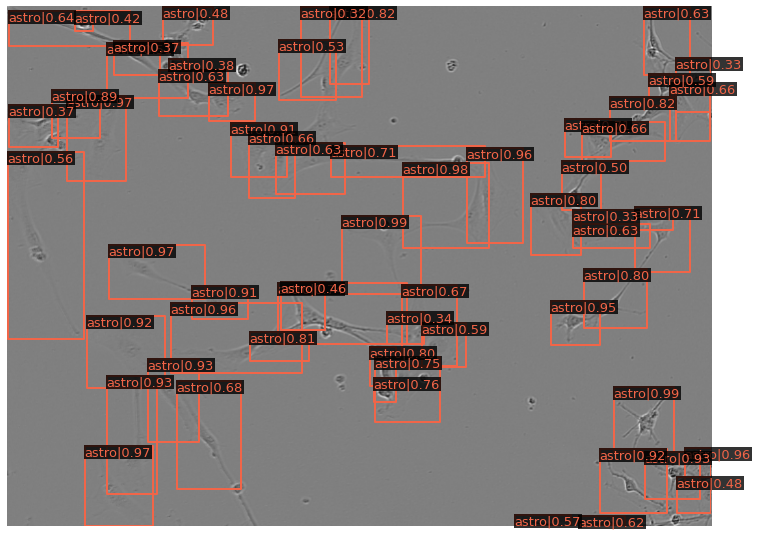

[>>>>>>>>>>>                        ] 1/3, 0.5 task/s, elapsed: 2s, ETA:     4s

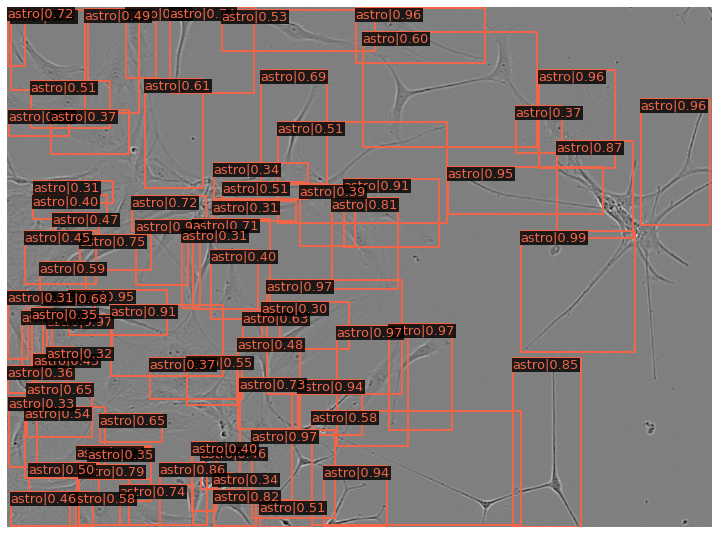

[>>>>>>>>>>>>>>>>>>>>>>>            ] 2/3, 0.6 task/s, elapsed: 3s, ETA:     2s

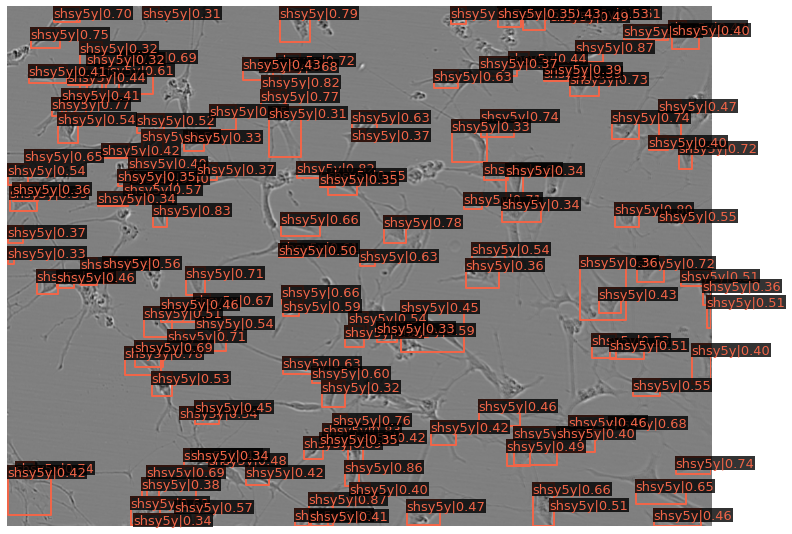

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 0.6 task/s, elapsed: 5s, ETA:     0s
writing results to output_dir


In [13]:
import argparse
import os
import os.path as osp
import time
import warnings

import mmcv
import torch
from mmcv import Config, DictAction
from mmcv.cnn import fuse_conv_bn
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmcv.runner import get_dist_info, init_dist, load_checkpoint, wrap_fp16_model
from mmdet.apis import multi_gpu_test, single_gpu_test
from mmdet.datasets import build_dataloader, build_dataset, replace_ImageToTensor
from mmdet.models import build_detector

from ssod.utils import patch_config 



DET_INFER(det_pkl_1, det_json_1, det_config_1_path, det_ckpt_1_path, 1, "bbox", data_annot_file_dir, data_test_dir)

# DET Inference - Model 2 (cascade_rcnn_resnest)


./models/det/det2_cascade_rcnn_resnest/configs/config_det2_cascade_rcnn_resnest.py


/content/drive/.shortcut-targets-by-id/1371Il8VcUbpuib0aKJ1e4HHMALcItZrc/Deep_Learning_Itay_Sagi/Project/GIT/install/mmdetection-2.18.0/mmdet/datasets/api_wrappers/coco_api.py:22: UserWarning: mmpycocotools is deprecated. Please install official pycocotools by "pip install pycocotools"
  UserWarning)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
load checkpoint from local path: ./models/det/det2_cascade_rcnn_resnest/final_weights/final_weights_det2_cascade_rcnn_resnest.pth


2022-03-06 07:47:37,488 - root - INFO - DeformConv2dPack backbone.layer2.0.conv2.conv is upgraded to version 2.
2022-03-06 07:47:37,495 - root - INFO - DeformConv2dPack backbone.layer2.1.conv2.conv is upgraded to version 2.
2022-03-06 07:47:37,500 - root - INFO - DeformConv2dPack backbone.layer2.2.conv2.conv is upgraded to version 2.
2022-03-06 07:47:37,506 - root - INFO - DeformConv2dPack backbone.layer2.3.conv2.conv is upgraded to version 2.
2022-03-06 07:47:37,511 - root - INFO - DeformConv2dPack backbone.layer3.0.conv2.conv is upgraded to version 2.
2022-03-06 07:47:37,519 - root - INFO - DeformConv2dPack backbone.layer3.1.conv2.conv is upgraded to version 2.
2022-03-06 07:47:37,524 - root - INFO - DeformConv2dPack backbone.layer3.2.conv2.conv is upgraded to version 2.
2022-03-06 07:47:37,529 - root - INFO - DeformConv2dPack backbone.layer3.3.conv2.conv is upgraded to version 2.
2022-03-06 07:47:37,534 - root - INFO - DeformConv2dPack backbone.layer3.4.conv2.conv is upgraded to ver

[                                                  ] 0/3, elapsed: 0s, ETA:

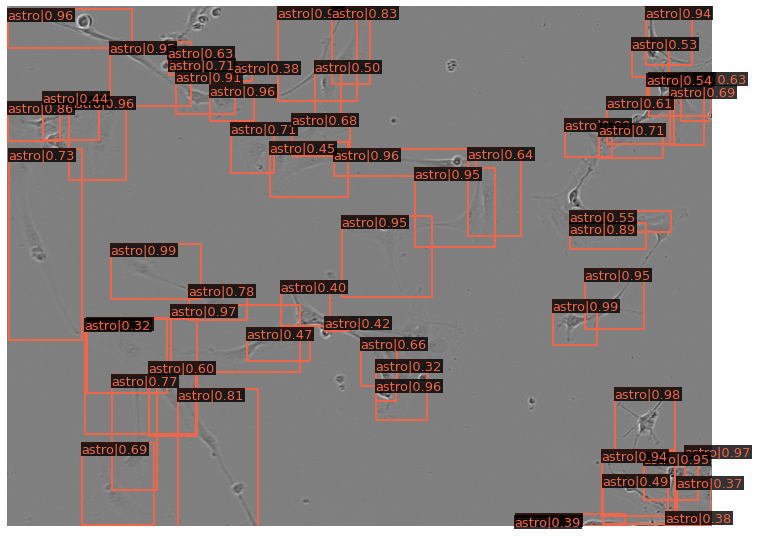

[>>>>>>>>>>>                        ] 1/3, 0.7 task/s, elapsed: 1s, ETA:     3s

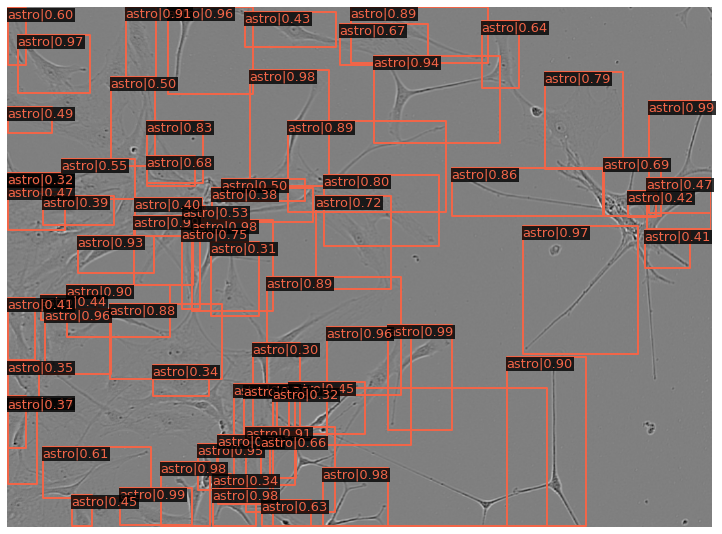

[>>>>>>>>>>>>>>>>>>>>>>>            ] 2/3, 0.8 task/s, elapsed: 3s, ETA:     1s

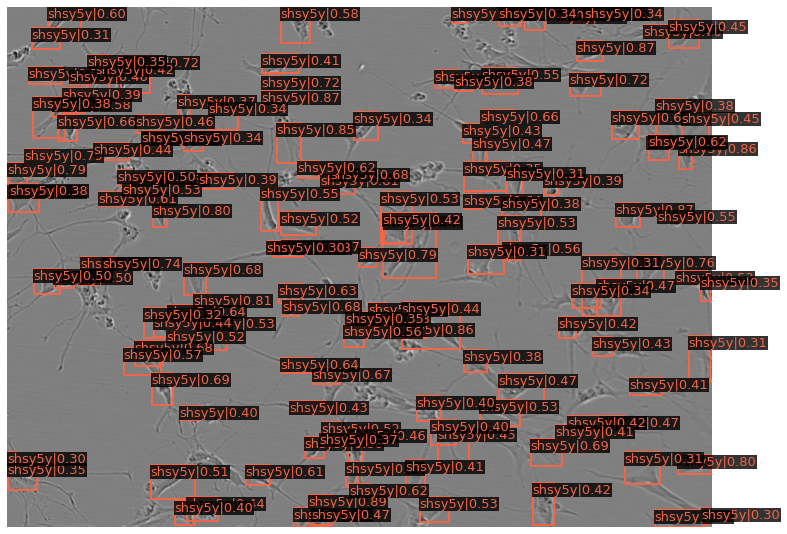

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 0.7 task/s, elapsed: 4s, ETA:     0s
writing results to output_dir


In [14]:
DET_INFER(det_pkl_2, det_json_2, det_config_2_path, det_ckpt_2_path, 1, "bbox", data_annot_file_dir, data_test_dir)

# DET Inference - Model 3 (faster_rcnn_swin)


./models/det/det3_faster_rcnn_swin/configs/config_det3_faster_rcnn_swin.py


/content/drive/.shortcut-targets-by-id/1371Il8VcUbpuib0aKJ1e4HHMALcItZrc/Deep_Learning_Itay_Sagi/Project/GIT/install/mmdetection-2.18.0/mmdet/datasets/api_wrappers/coco_api.py:22: UserWarning: mmpycocotools is deprecated. Please install official pycocotools by "pip install pycocotools"
  UserWarning)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
load checkpoint from local path: ./models/det/det3_faster_rcnn_swin/final_weights/final_weights_det3_faster_rcnn_swin.pth
[                                                  ] 0/3, elapsed: 0s, ETA:

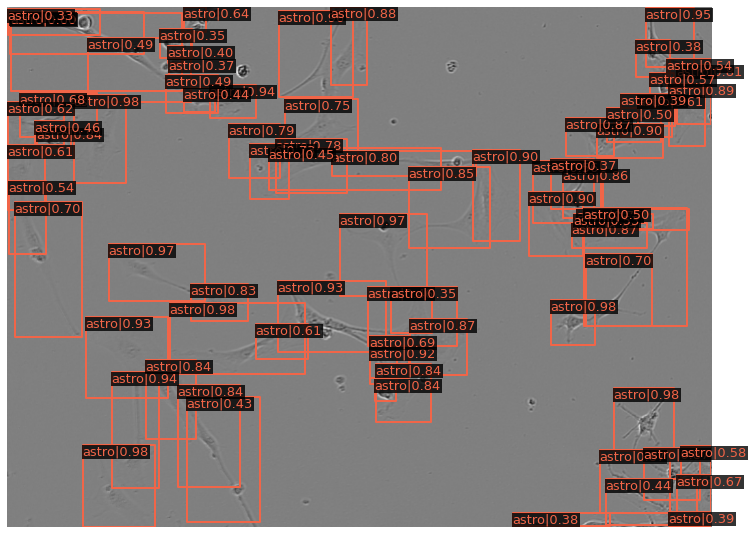

[>>>>>>>>>>>                        ] 1/3, 0.8 task/s, elapsed: 1s, ETA:     3s

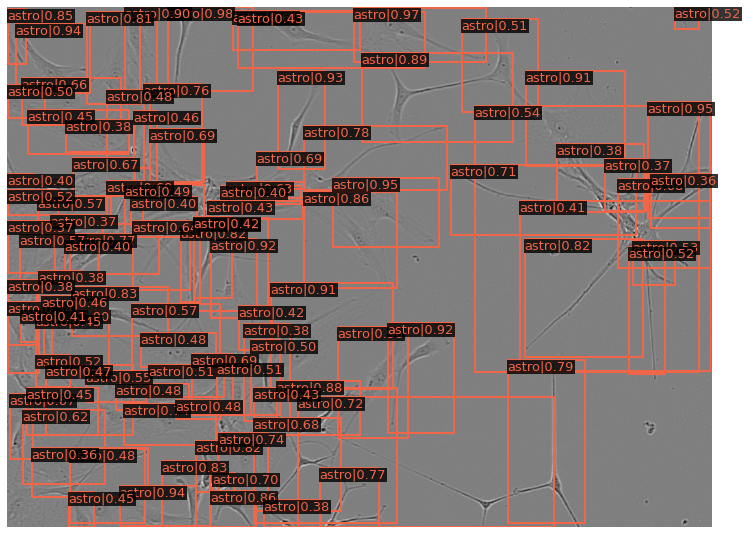

[>>>>>>>>>>>>>>>>>>>>>>>            ] 2/3, 0.9 task/s, elapsed: 2s, ETA:     1s

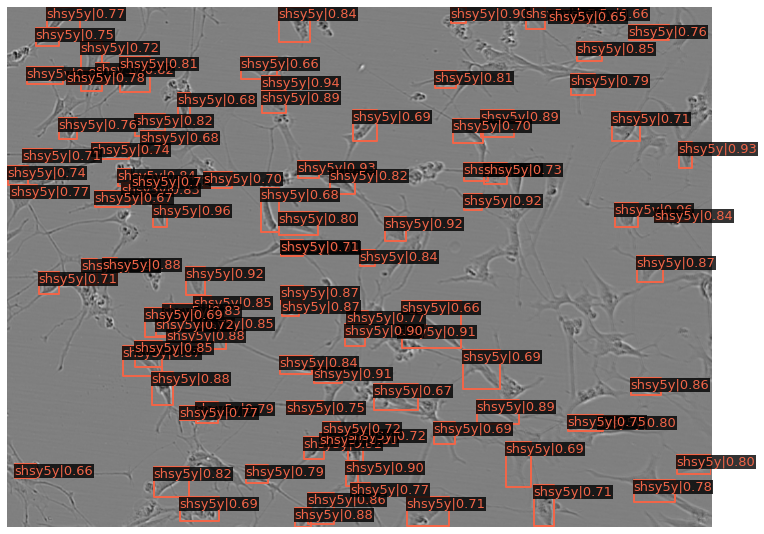

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 0.9 task/s, elapsed: 3s, ETA:     0s
writing results to output_dir


In [15]:
DET_INFER(det_pkl_3, det_json_3, det_config_3_path, det_ckpt_3_path, 1, "bbox", data_annot_file_dir, data_test_dir)

# DET Inference - Model 4 (softteacher_faster_rcnn_resnext)


./models/det/det4_softteacher_faster_rcnn_resnext/configs/config_det4_softteacher_faster_rcnn_resnext.py


/content/drive/.shortcut-targets-by-id/1371Il8VcUbpuib0aKJ1e4HHMALcItZrc/Deep_Learning_Itay_Sagi/Project/GIT/install/mmdetection-2.18.0/mmdet/datasets/api_wrappers/coco_api.py:22: UserWarning: mmpycocotools is deprecated. Please install official pycocotools by "pip install pycocotools"
  UserWarning)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
load checkpoint from local path: ./models/det/det4_softteacher_faster_rcnn_resnext/final_weights/final_weights_det4_softteacher_faster_rcnn_resnext.pth
[                                                  ] 0/3, elapsed: 0s, ETA:

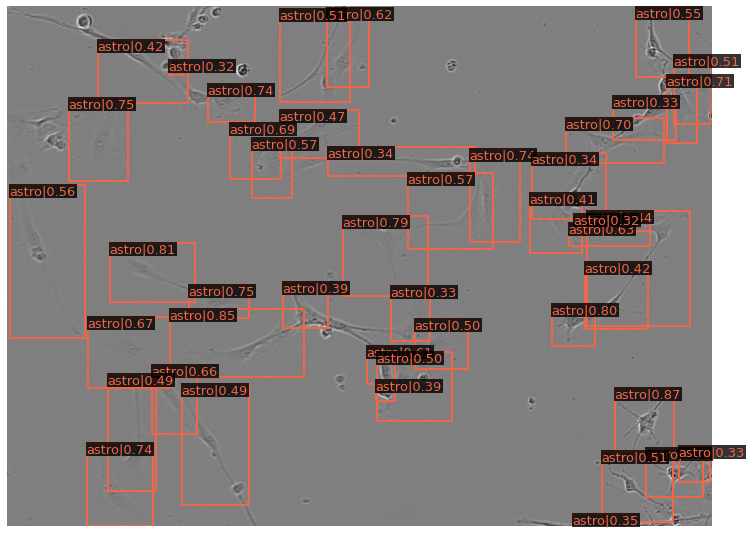

[>>>>>>>>>>>                        ] 1/3, 0.8 task/s, elapsed: 1s, ETA:     2s

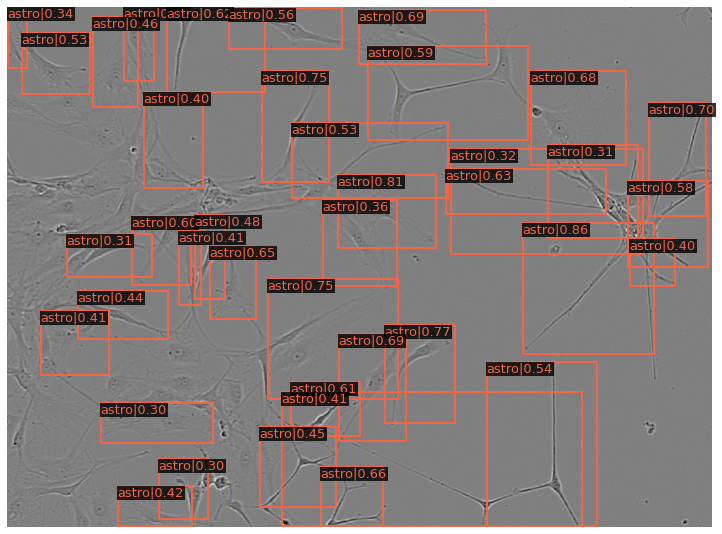

[>>>>>>>>>>>>>>>>>>>>>>>            ] 2/3, 0.9 task/s, elapsed: 2s, ETA:     1s

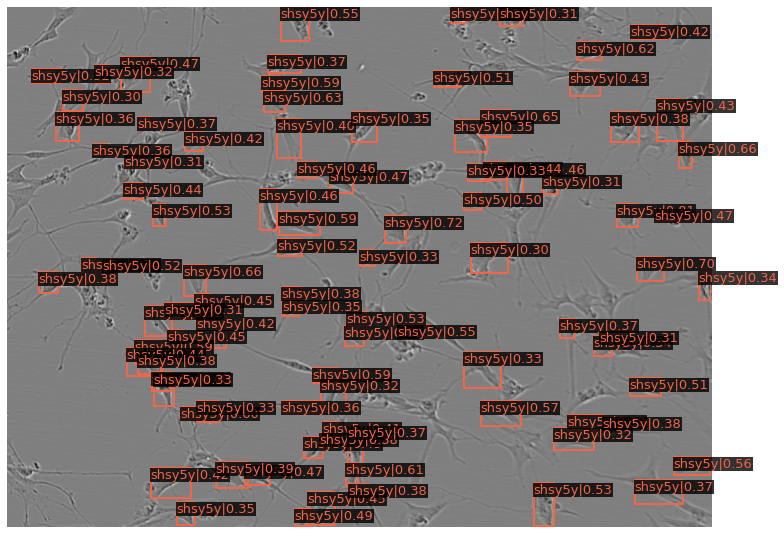

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 0.9 task/s, elapsed: 3s, ETA:     0s
writing results to output_dir


In [16]:
DET_INFER(det_pkl_4, det_json_4, det_config_4_path, det_ckpt_4_path, 1, "bbox", data_annot_file_dir, data_test_dir)

# WBF

In [17]:
with open(det_pkl_1, 'rb') as f:
    bbox_model1 = pickle.load(f)
with open(det_pkl_2, 'rb') as f:
    bbox_model2 = pickle.load(f)
with open(det_pkl_3, 'rb') as f:
    bbox_model3 = pickle.load(f)
with open(det_pkl_4, 'rb') as f:
    bbox_model4 = pickle.load(f)


bbox_models = [bbox_model1,bbox_model2,bbox_model3,bbox_model4]

merged_bbox_wbf = wbf_si(bbox_models,img_scale,weights,iou_thr,skip_box_thr) 

pickle.dump(merged_bbox_wbf, open(wbf_output_file_path, 'wb'))

# SEG Inference

In [18]:
pred_file_path = wbf_output_file_path

In [19]:
print(f"seg_pkl: {seg_pkl}")
print(f"seg_json: {seg_json}")
print(f"seg_config_path: {seg_config_path}")
print(f"seg_ckpt_path: {seg_ckpt_path}")
print(f"pred_file_path: {pred_file_path}")
print(f"data_annot_file_dir: {data_annot_file_dir}")
print(f"data_test_dir: {data_test_dir}")


seg_pkl: ./output_and_results/seg/seg_results_test01.pkl
seg_json: ./output_and_results/seg/seg_results_test01.json
seg_config_path: ./models/seg/seg_upernet_swin/configs/config_seg_upernet_swin.py
seg_ckpt_path: ./models/seg/seg_upernet_swin/final_weights/final_weights_seg_upernet_swin.pth
pred_file_path: ./output_and_results/det/wbf_01.pkl
data_annot_file_dir: /content/drive/MyDrive/Deep_Learning_Itay_Sagi/Project/Sartorius_Cell_Instance_Segmentation/data/test_annot.json
data_test_dir: /content/drive/MyDrive/Deep_Learning_Itay_Sagi/Project/Sartorius_Cell_Instance_Segmentation/data/test/


In [20]:
from mmcv.utils import DictAction
from mmseg.apis import multi_gpu_test, single_gpu_test
from mmseg.datasets import build_dataloader, build_dataset
from mmseg.models import build_segmentor

mmdet_style_results = SEG_INFER(seg_pkl, seg_json, seg_config_path, seg_ckpt_path, pred_file_path, "dummy", data_annot_file_dir, data_test_dir)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/content/drive/.shortcut-targets-by-id/1371Il8VcUbpuib0aKJ1e4HHMALcItZrc/Deep_Learning_Itay_Sagi/Project/GIT/install/mmdetection-2.18.0/mmdet/datasets/api_wrappers/coco_api.py:22: UserWarning: mmpycocotools is deprecated. Please install official pycocotools by "pip install pycocotools"
  UserWarning)


load checkpoint from local path: ./models/seg/seg_upernet_swin/final_weights/final_weights_seg_upernet_swin.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 862/862, 23.1 task/s, elapsed: 37s, ETA:     0s
writing results to ./output_and_results/seg/seg_results_test01.pkl


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:350: UserWarning: The behavior of ``args_seg["out"]`` has been changed since MMSeg v0.16, the pickled outputs could be seg map as type of np.array, pre-eval results or file paths for ``dataset.format_results()``.



writing results to: /kaggle/working/mmdet_style_results.pkl


-------------------------------- Kaggle Inference: ---------------------------------------

# Kaggle - Importations

In [21]:
#############
# Importations

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.random
import random

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import sklearn
import torchvision
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import PIL
from PIL import Image, ImageEnhance
import albumentations as A
import albumentations 
from albumentations.pytorch import ToTensorV2

import glob
from pathlib import Path
import pycocotools
from pycocotools import mask
import re

from mmdet.apis import train_detector
from mmdet.apis import inference_detector, init_detector, show_result_pyplot


#!pip install cupy
#import cupy as cp
import gc
import shutil

# Kaggle - Helper Functions

In [22]:
IMG_WIDTH = 704
IMG_HEIGHT = 520

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))

'''def get_mask_from_result(result):
    d = {True : 1, False : 0}
    u,inv = np.unique(result,return_inverse = True)
    mk = cp.array([d[x] for x in u])[inv].reshape(result.shape)
#     print(mk.shape)
    return mk'''

def does_overlap(mask, other_masks):
    for other_mask in other_masks:
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            return True
    return False


def remove_overlapping_pixels(mask, other_masks):
    for other_mask in other_masks:
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            print("Overlap detected")
            mask[np.logical_and(mask, other_mask)] = 0
    return mask

def get_img_and_mask(img_path, annotation, width, height):
    """ Capture the relevant image array as well as the image mask """
    img_mask = np.zeros((height, width), dtype=np.uint8)
    for i, annot in enumerate(annotation): 
        img_mask = np.where(rle_decode(annot, (height, width))!=0, i, img_mask)
    img = cv2.imread(img_path)[..., ::-1]
    return img[..., 0], img_mask

def plot_img_and_mask(img, mask, invert_img=True, boost_contrast=True):
    """ Function to take an image and the corresponding mask and plot
    
    Args:
        img (np.arr): 1 channel np arr representing the image of cellular structures
        mask (np.arr): 1 channel np arr representing the instance masks (incrementing by one)
        invert_img (bool, optional): Whether or not to invert the base image
        boost_contrast (bool, optional): Whether or not to boost contrast of the base image
        
    Returns:
        None; Plots the two arrays and overlays them to create a merged image
    """
    plt.figure(figsize=(20,10))
    
    plt.subplot(1,3,1)
    _img = np.tile(np.expand_dims(img, axis=-1), 3)
    
    # Flip black-->white ... white-->black
    if invert_img:
        _img = _img.max()-_img
        
    if boost_contrast:
        _img = np.asarray(ImageEnhance.Contrast(Image.fromarray(_img)).enhance(16))
        
    plt.imshow(_img)
    plt.axis(False)
    plt.title("Cell Image", fontweight="bold")
    
    plt.subplot(1,3,2)
    _mask = np.zeros_like(_img)
    _mask[..., 0] = mask
    plt.imshow(mask, cmap='rainbow')
    plt.axis(False)
    plt.title("Instance Segmentation Mask", fontweight="bold")
    
    merged = cv2.addWeighted(_img, 0.75, np.clip(_mask, 0, 1)*255, 0.25, 0.0,)
    plt.subplot(1,3,3)
    plt.imshow(merged)
    plt.axis(False)
    plt.title("Cell Image w/ Instance Segmentation Mask Overlay", fontweight="bold")
    
    plt.tight_layout()
    plt.show()
    
def pkl_labels_func_kaggle(pkl, j):
    class0_n=len(pkl[j][0][0])
    class1_n=len(pkl[j][0][1])
    class2_n=len(pkl[j][0][2])
    pkl_labels=[]
    for i in range(class0_n):
        pkl_labels.append(0)
    for i in range(class1_n):
        pkl_labels.append(1)
    for i in range(class2_n):
        pkl_labels.append(2)
    
    return np.asarray(pkl_labels)

# Kaggle - Inference

Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
(51, 520, 704)
(51, 5)
(51,)
167


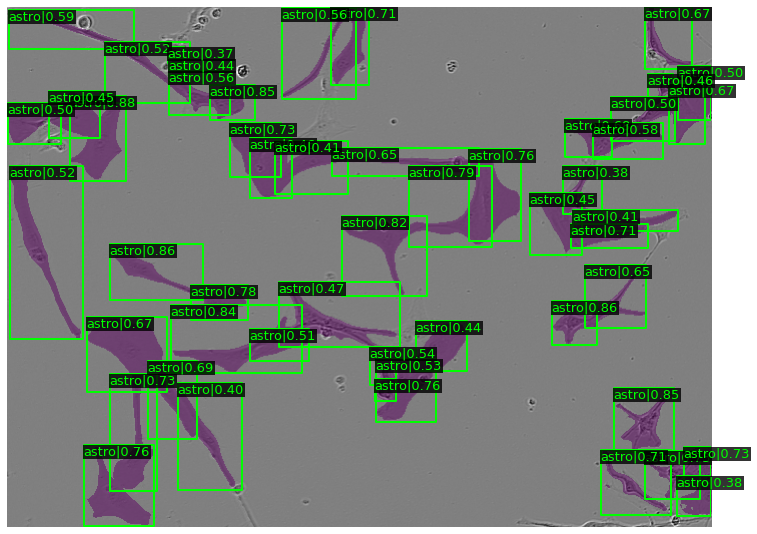

Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
(45, 520, 704)
(45, 5)
(45,)
233


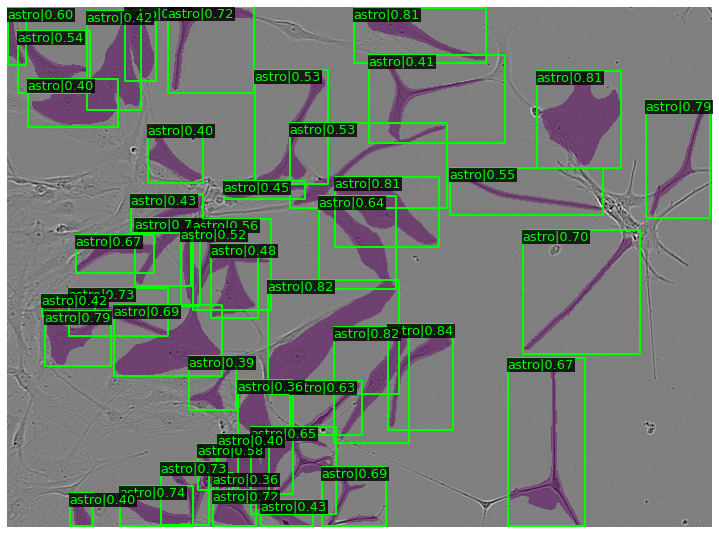

Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
Overlap detected
(119, 520, 704)
(119, 5)
(119,)
247


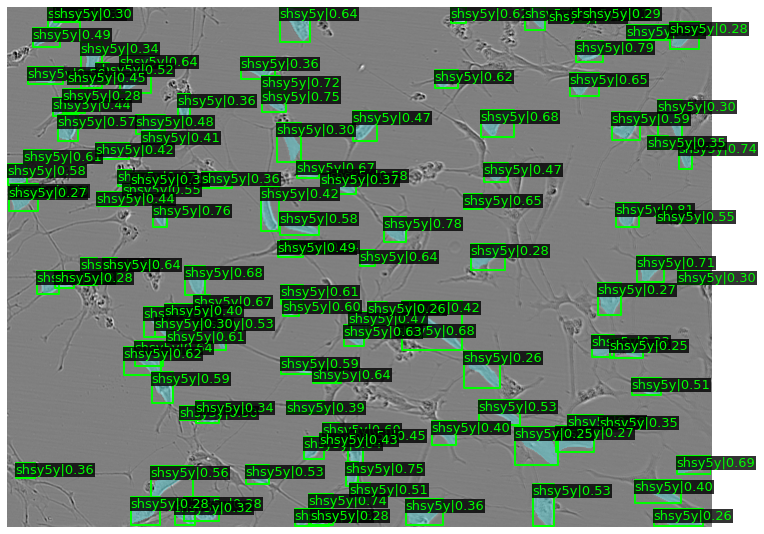

In [23]:
confidence_thresholds = {0: 0.25, 1: 0.55, 2: 0.35} #["shsy5y", "cort", "astro"],
segms = []
files = []


import copy
from mmdet.core.visualization import imshow_det_bboxes

mmdet_style_results_forplot = copy.deepcopy(mmdet_style_results)

for j, image in enumerate(data_root['images']):

    img = mmcv.imread(image['file_name'])
    idx_del_bbox = []
    idx_del_labels = []
    pkl_bboxes = np.concatenate((mmdet_style_results[j][0][0],mmdet_style_results[j][0][1],mmdet_style_results[j][0][2])).tolist()
    pkl_labels = pkl_labels_func_kaggle(mmdet_style_results, j).tolist()

    previous_masks = []
    previous_masks_for_plot = []
    num_of_thresholded=0
    m=0
    for i, classe in enumerate(mmdet_style_results[j][0]):
        if len(classe) != (0, 5):
            bbs = classe
            sgs = mmdet_style_results[j][1][i]
            k=0
            for bb, sg in zip(bbs,sgs):
                box = bb[:4]
                cnf = bb[4]

                if cnf >= confidence_thresholds[i]:
                    mask = pycocotools.coco.maskUtils.decode(sg) 
                    mask = remove_overlapping_pixels(mask, previous_masks)
                    previous_masks_for_plot.append(np.array(mask, dtype=bool)) 
                    previous_masks.append(mask)
                else:
                    num_of_thresholded+=1
                    idx_del_bbox.append(m)
                    idx_del_labels.append(m)
                m+=1
    
    for i in reversed(idx_del_bbox):
        del pkl_bboxes[i]
    
    for i in reversed(idx_del_labels):
        del pkl_labels[i]

    print(np.asarray(previous_masks_for_plot).shape)
    print(np.asarray(pkl_bboxes).shape)
    print(np.asarray(pkl_labels).shape)
    print(num_of_thresholded)
    imshow_det_bboxes(img,
                      np.asarray(pkl_bboxes),
                      np.asarray(pkl_labels),
                      segms=np.asarray(previous_masks_for_plot),
                      class_names=["shsy5y", "cort", "astro"],
                      score_thr=0,
                      show=True)
    
    for mk in previous_masks:
            rle_mask = rle_encoding(mk)
            segms.append(rle_mask)
            files.append(image['file_name'].split('/')[-1].split('.')[0])

In [24]:
indexes = []
for i, segm in enumerate(segms):
    if segm == '':
        indexes.append(i)
        
for element in sorted(indexes, reverse = True):
    del segms[element]
    del files[element]
    
files = pd.Series(files, name='id')
preds = pd.Series(segms, name='predicted')

In [25]:
preds

0      269588 5 270291 7 270994 10 271698 10 272401 1...
1      169067 8 169770 11 170471 15 171175 17 171879 ...
2      218517 3 219220 5 219923 6 220627 5 221330 6 2...
3      207538 3 208241 5 208944 8 209647 9 210351 10 ...
4      151770 1 152471 10 153151 10 153173 15 153845 ...
                             ...                        
210    235042 5 235743 12 236446 14 237151 15 237855 ...
211    130947 2 131651 4 132355 7 133059 13 133763 16...
212    296894 7 297597 14 298301 18 299005 21 299709 ...
213    208752 4 209455 7 210158 9 210861 11 211564 13...
214    355466 4 356170 5 356875 5 357579 7 358283 9 3...
Name: predicted, Length: 215, dtype: object

In [26]:
submission_df = pd.concat([files, preds], axis=1)
submission_df.to_csv('./output_and_results/submission.csv', index=False)
submission_df

id                                          predicted
0    d48ec7815252  269588 5 270291 7 270994 10 271698 10 272401 1...
1    d48ec7815252  169067 8 169770 11 170471 15 171175 17 171879 ...
2    d48ec7815252  218517 3 219220 5 219923 6 220627 5 221330 6 2...
3    d48ec7815252  207538 3 208241 5 208944 8 209647 9 210351 10 ...
4    d48ec7815252  151770 1 152471 10 153151 10 153173 15 153845 ...
..            ...                                                ...
210  7ae19de7bc2a  235042 5 235743 12 236446 14 237151 15 237855 ...
211  7ae19de7bc2a  130947 2 131651 4 132355 7 133059 13 133763 16...
212  7ae19de7bc2a  296894 7 297597 14 298301 18 299005 21 299709 ...
213  7ae19de7bc2a  208752 4 209455 7 210158 9 210861 11 211564 13...
214  7ae19de7bc2a  355466 4 356170 5 356875 5 357579 7 358283 9 3...

[215 rows x 2 columns]